In [1]:
pip install torch torchvision numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Select 3 classes (e.g., 'cat', 'dog', 'bird')
selected_classes = ['cat', 'dog', 'bird']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(train_dataset.classes)}
selected_idx = [class_to_idx[cls] for cls in selected_classes]

# Function to filter datasets
def filter_dataset(dataset, selected_idx):
    indices = [i for i, (_, label) in enumerate(dataset) if label in selected_idx]
    return Subset(dataset, indices)

# Filter train and test datasets
filtered_train_dataset = filter_dataset(train_dataset, selected_idx)
filtered_test_dataset = filter_dataset(test_dataset, selected_idx)

# Define a custom dataset class
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, selected_classes):
        self.dataset = dataset
        self.selected_classes = selected_classes
        self.label_map = {original: new for new, original in enumerate(selected_classes)}
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # Remap the label
        label = self.label_map[label]
        return image, label

# Wrap filtered datasets into the custom dataset class
# Filter the train and test datasets
selected_classes = [class_to_idx['bird'], class_to_idx['cat'], class_to_idx['dog']]
custom_train_dataset = CustomCIFAR10Dataset(filtered_train_dataset, selected_classes)
custom_test_dataset = CustomCIFAR10Dataset(filtered_test_dataset, selected_classes)

# Stratified split of training dataset (80% train, 20% validation)
train_len = int(0.8 * len(custom_train_dataset))
val_len = len(custom_train_dataset) - train_len
train_dataset, val_dataset = random_split(custom_train_dataset, [train_len, val_len])

# Stratified sampling for the test dataset (ensure 1,000 samples per class)
test_indices = []
# Initialize class counts for remapped labels
class_counts = {label: 0 for label in range(len(selected_classes))}  # {0: 0, 1: 0, 2: 0}

# Collect indices for balanced test samples (1,000 per class)
test_indices = []
for idx, (_, label) in enumerate(custom_test_dataset):
    if class_counts[label] < 1000:  # Check remapped labels (0, 1, 2)
        test_indices.append(idx)
        class_counts[label] += 1
        if all(count == 1000 for count in class_counts.values()):  # Stop if all classes are filled
            break

# Create the final test dataset
custom_test_dataset = Subset(custom_test_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(custom_test_dataset, batch_size=64, shuffle=False)

# Print dataset sizes
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(custom_test_dataset)} samples")

Files already downloaded and verified
Files already downloaded and verified
Train Dataset: 12000 samples
Validation Dataset: 3000 samples
Test Dataset: 3000 samples


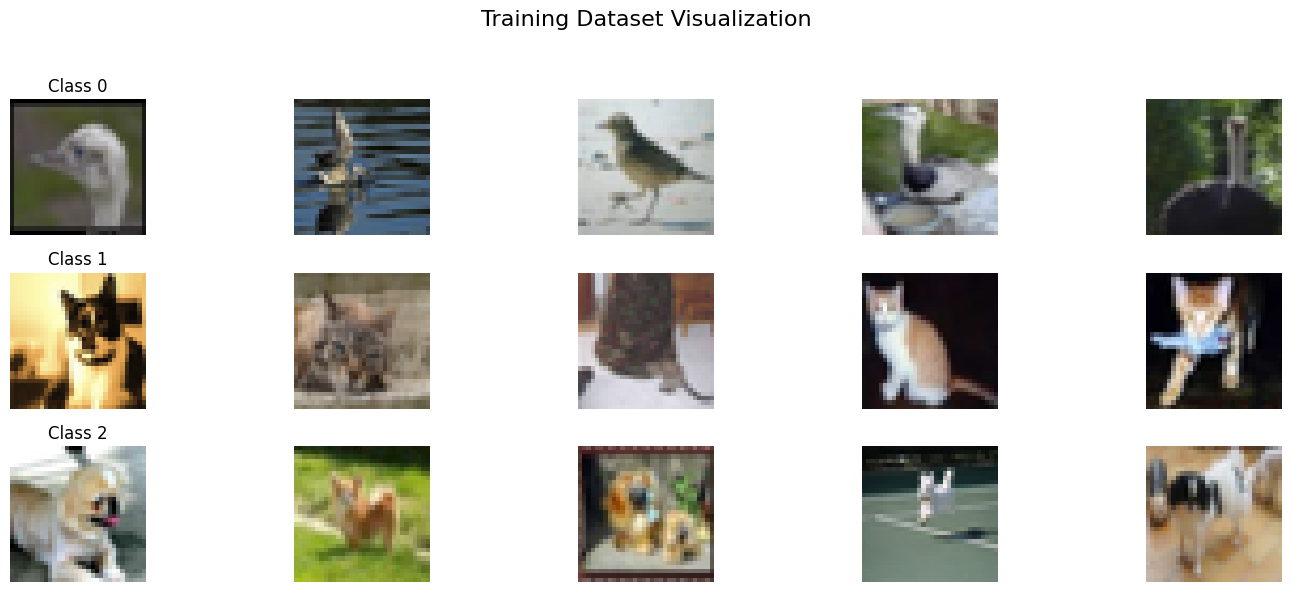

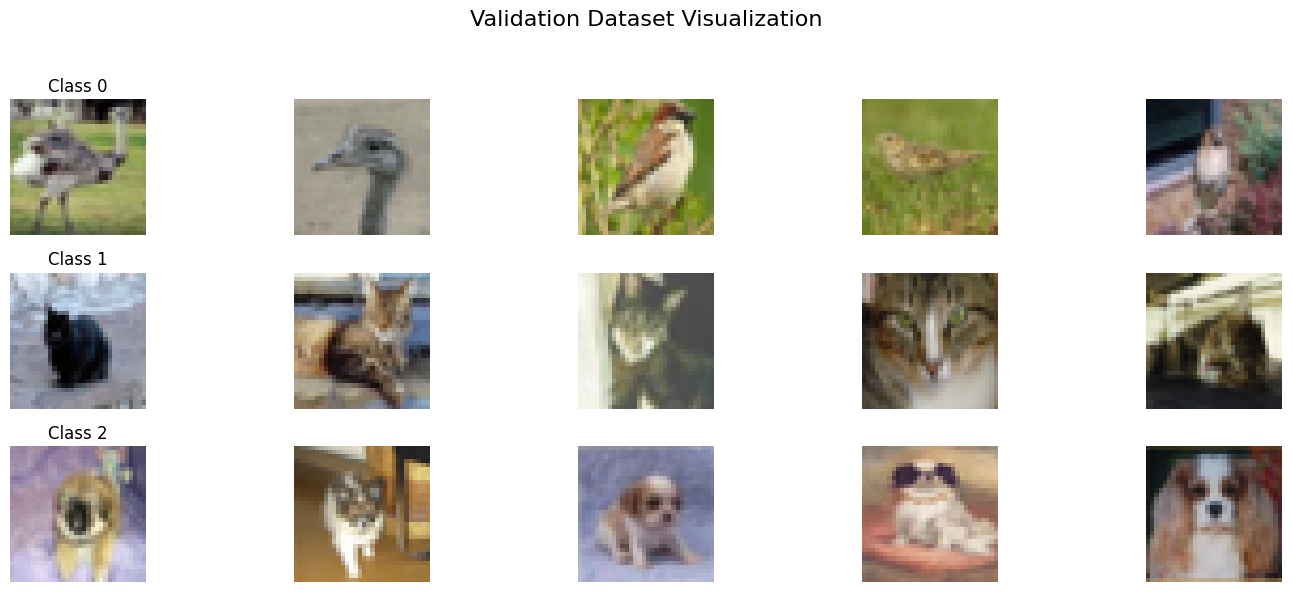

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to denormalize and convert tensor to image
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert from CHW to HWC
    return img

# Function to plot images
def plot_images(dataset, dataset_name, remapped_classes, num_images=5):
    class_samples = {cls_idx: [] for cls_idx in remapped_classes}  # Dictionary to store samples per class
    for img, label in dataset:
        if label in remapped_classes and len(class_samples[label]) < num_images:
            class_samples[label].append(img)
        if all(len(class_samples[cls_idx]) == num_images for cls_idx in remapped_classes):
            break
    
    # Plot images
    fig, axs = plt.subplots(len(remapped_classes), num_images, figsize=(15, 6))
    fig.suptitle(f'{dataset_name} Dataset Visualization', fontsize=16)
    
    for i, cls_idx in enumerate(remapped_classes):
        for j in range(num_images):
            axs[i, j].imshow(denormalize(class_samples[cls_idx][j]))
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(f'Class {cls_idx}', fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Use remapped class indices [0, 1, 2]
remapped_classes = [0, 1, 2]  # Classes after remapping

# Visualize training dataset
plot_images(train_dataset, "Training", remapped_classes, num_images=5)

# Visualize validation dataset
plot_images(val_dataset, "Validation", remapped_classes, num_images=5)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 4 * 4, 16)  # Update input size
        self.fc2 = nn.Linear(16, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the model
num_classes = 3  # For the selected CIFAR-10 classes
model = SimpleCNN(num_classes=num_classes)

# Print model summary
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


In [5]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = SimpleCNN(num_classes=3).to(device)

# Define the loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track training loss and accuracy
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total)
    
    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Track validation loss and accuracy
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    
    # Log results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
    print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

# Save the model
torch.save(model.state_dict(), "simple_cnn_model.pth")
print("Model saved as 'simple_cnn_model.pth'")

Using device: cpu
Epoch 1/15
  Train Loss: 0.9832, Train Accuracy: 0.5059
  Val Loss: 0.8917, Val Accuracy: 0.5923
Epoch 2/15
  Train Loss: 0.8733, Train Accuracy: 0.5982
  Val Loss: 0.8191, Val Accuracy: 0.6247
Epoch 3/15
  Train Loss: 0.8231, Train Accuracy: 0.6211
  Val Loss: 0.7826, Val Accuracy: 0.6500
Epoch 4/15
  Train Loss: 0.7918, Train Accuracy: 0.6398
  Val Loss: 0.7597, Val Accuracy: 0.6620
Epoch 5/15
  Train Loss: 0.7597, Train Accuracy: 0.6581
  Val Loss: 0.7328, Val Accuracy: 0.6727
Epoch 6/15
  Train Loss: 0.7330, Train Accuracy: 0.6768
  Val Loss: 0.7214, Val Accuracy: 0.6810
Epoch 7/15
  Train Loss: 0.7040, Train Accuracy: 0.6949
  Val Loss: 0.6968, Val Accuracy: 0.6910
Epoch 8/15
  Train Loss: 0.6822, Train Accuracy: 0.7042
  Val Loss: 0.6941, Val Accuracy: 0.6860
Epoch 9/15
  Train Loss: 0.6649, Train Accuracy: 0.7115
  Val Loss: 0.6976, Val Accuracy: 0.6960
Epoch 10/15
  Train Loss: 0.6504, Train Accuracy: 0.7174
  Val Loss: 0.6916, Val Accuracy: 0.6933
Epoch 11/15

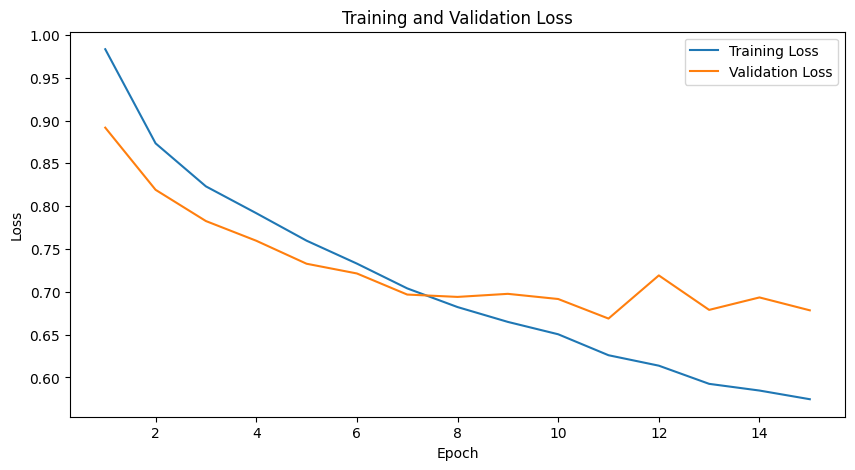

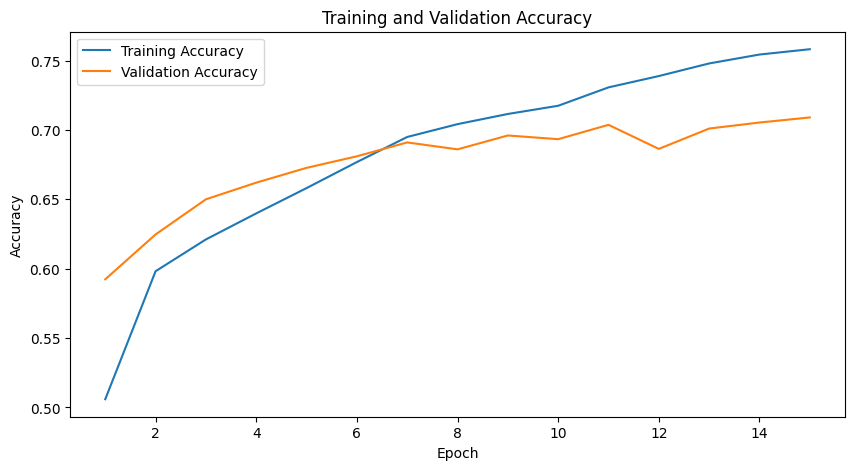

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch.nn.functional as F

# Evaluate model on the test dataset
model.eval()  # Set model to evaluation mode
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Accuracy calculation
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

# Compute accuracy
test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute classification report for F1-score
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1", "Class 2"])
print("Classification Report:")
print(report)

Test Accuracy: 0.7023
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.80      0.78      1000
     Class 1       0.71      0.55      0.62      1000
     Class 2       0.65      0.76      0.70      1000

    accuracy                           0.70      3000
   macro avg       0.70      0.70      0.70      3000
weighted avg       0.70      0.70      0.70      3000



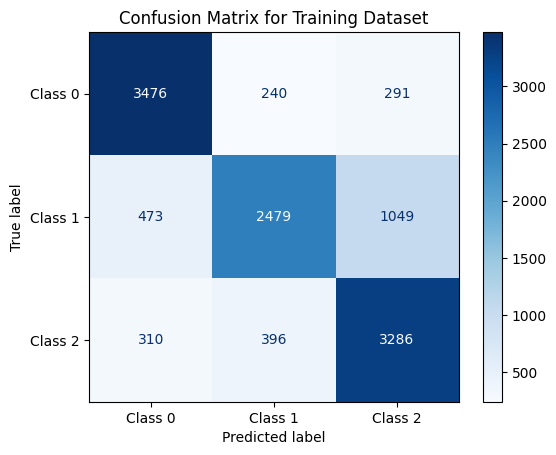

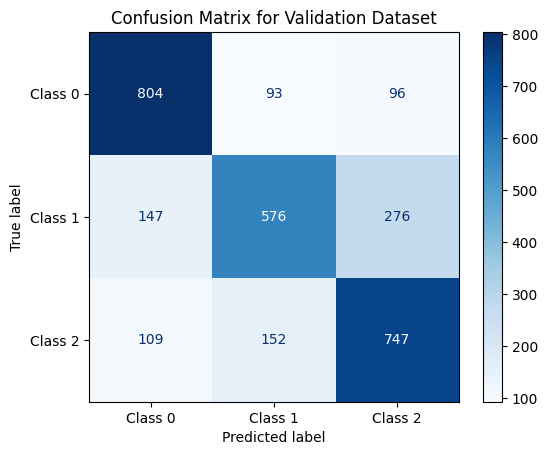

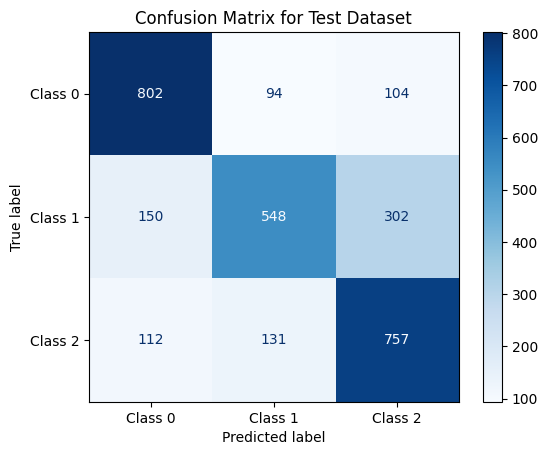

In [8]:
# Helper function to plot confusion matrix
def plot_confusion_matrix(preds, labels, dataset_name):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {dataset_name} Dataset")
    plt.show()

# Plot confusion matrix for train, validation, and test datasets
# Train Confusion Matrix
train_preds, train_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
plot_confusion_matrix(train_preds, train_labels, "Training")

# Validation Confusion Matrix
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
plot_confusion_matrix(val_preds, val_labels, "Validation")

# Test Confusion Matrix
plot_confusion_matrix(all_preds, all_labels, "Test")